In [2]:
import duckdb
import pyarrow as pa
import pyarrow.parquet as pq

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import zipfile
import os
from pathlib import Path

## Create a duckdb connexion

In this tutorial, we use duckdb as in memory db without any persistence. We can easily use the below config to persiste the data in a local file system

```python
conn = duckdb.connect(database="/tmp/my_database.db")
```

In [3]:
# Connexion à DuckDB
conn = duckdb.connect(database=':memory:', read_only=False)

# Exécution d'une requête SQL pour cree une table
cursor = conn.cursor()
cursor.execute("CREATE TABLE sample_table(id INTEGER, name VARCHAR)")
cursor.execute("INSERT INTO sample_table VALUES (1, 'John'), (2, 'Alice'), (3, 'Bob')")

# Récupération des résultats de la requête
result = cursor.execute("SELECT * FROM sample_table").fetchall()
print("Résultat de la requête : ", result)



Résultat de la requête :  [(1, 'John'), (2, 'Alice'), (3, 'Bob')]


## Use duckdb to read parquet file

In [4]:
data_path = Path.cwd().parent / "data"
fr_immo_raw_path = (data_path / "fr_immo_transactions.parquet").as_posix()

In [5]:
# Chargement du fichier Parquet
table_name = "fr_immo"
cursor = conn.cursor()
cursor.execute(f"CREATE TABLE {table_name} AS SELECT * FROM parquet_scan('{fr_immo_raw_path}')")


In [15]:
def show_tables():
    # List all tables in the database
    tables = conn.execute("SHOW TABLES").fetchdf()

    # Print the table names
    print(f"Exsiting table list:\n{tables}")

show_tables()

Exsiting table list:
           name
0    fr_fiscaux
1       fr_immo
2  sample_table


In [10]:
# Affichage des 5 premières lignes de table immo_fr
def show_sample_rows(table_name:str):
    result = cursor.execute(f"SELECT * FROM {table_name} LIMIT 5").fetchdf()
    print(f"Les 5 premières lignes du table{table_name}\n:", result)

In [11]:
show_sample_rows(table_name)

Les 5 premières lignes du tablefr_immo
:    id_transaction date_transaction      prix departement  id_ville  \
0          141653       2014-01-02  197000.0          01       427   
1          141970       2014-01-02  157500.0          01       451   
2          139240       2014-01-02  112000.0          01       365   
3          146016       2014-01-02  173020.0          01       202   
4          145911       2014-01-03   88000.0          01       283   

                  ville  code_postal                      adresse  \
0               TREVOUX         1600           6346 MTE DES LILAS   
1                VIRIAT         1440       1369 RTE DE STRASBOURG   
2  SAINT-JEAN-SUR-VEYLE         1290   5174  SAINT JEAN SUR VEYLE   
3               LAGNIEU         1150  21 GR GRANDE RUE DE BULLIEZ   
4               OYONNAX         1100          29B RUE DE LA FORGE   

  type_batiment  n_pieces  surface_habitable   latitude  longitude  
0   Appartement         4                 84  45.94230

In [8]:
## Check the schema and basic stats of the table

In [12]:
# Statistiques de base sur les colonnes
def show_schema(table_name:str)->None:
    table_schema = conn.execute(f"""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = '{table_name}'
    """).fetchdf()

    print(f"Schema de table : {table_name}")
    print(f"{table_schema}")

In [13]:
show_schema(table_name)

Schema de table : fr_immo
          column_name     data_type
0      id_transaction       INTEGER
1    date_transaction  TIMESTAMP_NS
2                prix        DOUBLE
3         departement       VARCHAR
4            id_ville       INTEGER
5               ville       VARCHAR
6         code_postal       INTEGER
7             adresse       VARCHAR
8       type_batiment       VARCHAR
9            n_pieces       INTEGER
10  surface_habitable       INTEGER
11           latitude        DOUBLE
12          longitude        DOUBLE


In [10]:
# Statistiques de base sur les données (pour les colonnes numériques)
numeric_columns_query = f"""
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = '{table_name}'
    AND data_type IN ('INTEGER', 'DOUBLE', 'FLOAT', 'DECIMAL')
"""
numeric_columns = conn.execute(numeric_columns_query).fetchall()

# Construction de la requête SQL pour les statistiques des colonnes numériques
stats_queries = []
for column in numeric_columns:
    column_name = column[0]
    stats_queries.append(f"""
        SELECT
            '{column_name}' AS column_name,
            AVG({column_name}) AS average,
            STDDEV({column_name}) AS standard_deviation,
            MIN({column_name}) AS min_value,
            MAX({column_name}) AS max_value
        FROM {table_name}
    """)

# Exécution des requêtes de statistiques et affichage des résultats
print("Statistiques des colonnes numériques :")
print("Nom de colonne / Moyenne / Ecart type / Minimum / Maximum")
for query in stats_queries:
    result = conn.execute(query).fetchall()
    print(result)

Statistiques des colonnes numériques :
Nom de colonne / Moyenne / Ecart type / Minimum / Maximum
[('id_transaction', 7739952.499090474, 4446977.8655904615, 1, 15058573)]
[('id_ville', 208.0698140243479, 171.9242239066142, 1, 909)]
[('code_postal', 52936.02979454411, 27696.004797471785, 1000, 97490)]
[('n_pieces', 3.524251132709874, 1.5448404739813182, 0, 112)]
[('surface_habitable', 82.18102442544625, 43.386028549398894, 0, 7626)]
[('prix', 225329.25414140944, 1663532.0597511746, 0.0, 3300000000.0)]
[('latitude', 46.269937361272454, 6.012010692496521, -21.3862188488928, 51.082059485914)]
[('longitude', 2.385461679804203, 6.443977622752839, -63.1520742420684, 55.8292394321594)]


## Q2. Which city is the most active in the real estate market?

Qulle est la ville le plus active sur le marche immobilier?
 

In [11]:
# count the transaction number per year per city

query = f"""
SELECT EXTRACT(YEAR FROM date_transaction) AS year, 
ville, 
COUNT(*) AS transaction_count
FROM {table_name}
GROUP BY year, ville
ORDER BY transaction_count desc;
"""

result = conn.execute(query).fetchdf()

# Print the grouped data
print(f"Nombre de transaction group by year et ville:\n{result}")

Nombre de transaction group by year et ville:
        year          ville  transaction_count
0       2017       TOULOUSE              10791
1       2021       TOULOUSE               9944
2       2022       TOULOUSE               9911
3       2019       TOULOUSE               9881
4       2022           NICE               9431
...      ...            ...                ...
312107  2017        MACOUBA                  1
312108  2020  GRAND RIVIERE                  1
312109  2018           MANA                  1
312110  2020         APATOU                  1
312111  2023    MARIPASOULA                  1

[312112 rows x 3 columns]


## Q3. Get the price of meter square per year and city

In [12]:
query = f"""
SELECT EXTRACT(YEAR FROM date_transaction) AS year, 
ville,
prix,
surface_habitable,
prix / surface_habitable AS prix_par_meter
FROM {table_name}
ORDER BY prix_par_meter desc;
"""

prix_par_meter_df = conn.execute(query).fetchdf()

# Print the grouped data
print(f"Nombre de transaction group by year et ville:\n{prix_par_meter_df}")

Nombre de transaction group by year et ville:
         year                   ville      prix  surface_habitable  \
0        2016                FARAMANS   50000.0                  0   
1        2017  SAINT CYR AU MONT D OR  420000.0                  0   
2        2017  SAINT CYR AU MONT D OR  215000.0                  0   
3        2019   SAINT-LAURENT-DE-MURE  207000.0                  0   
4        2019   SAINT-LAURENT-DE-MURE  235000.0                  0   
...       ...                     ...       ...                ...   
9141568  2015    BOULOGNE-BILLANCOURT       0.0                 89   
9141569  2015               MONTROUGE       0.0                 84   
9141570  2015       NEUILLY-SUR-SEINE       0.0                210   
9141571  2015                  ANTONY       0.0                 86   
9141572  2015        LEVALLOIS-PERRET       0.0                 39   

         prix_par_meter  
0                   inf  
1                   inf  
2                   inf  
3        

In [29]:
prix_par_meter_tab_name ="price_par_meter"

query = f"""
CREATE OR REPlACE TEMP TABLE {prix_par_meter_tab_name} AS
SELECT * FROM
(
SELECT EXTRACT(YEAR FROM date_transaction) AS year, 
departement,
id_ville,
ville,
prix,
surface_habitable,
prix / surface_habitable AS prix_par_meter
FROM {table_name}
) AS prix_data
WHERE prix > 10000 and prix < 5000000 and surface_habitable > 10;
"""

result = conn.execute(query)



In [20]:
prix_par_meter_df = conn.execute(f"select * from {prix_par_meter_tab_name} order by prix_par_meter desc").fetchdf()

# Print the grouped data
print(f"Prix par metre carre group by year et ville:\n{prix_par_meter_df}")

Prix par metre carre group by year et ville:
         year departement  id_ville                   ville       prix  \
0        2017          75       118                PARIS 18  4700000.0   
1        2020          75       118                PARIS 18  4350000.0   
2        2015          75       102                PARIS 02  4600000.0   
3        2024          83       119            SAINT TROPEZ  4450000.0   
4        2021          75       102                PARIS 02  4500000.0   
...       ...         ...       ...                     ...        ...   
9069379  2019          04        19           BARCELONNETTE    12000.0   
9069380  2024          75       116                PARIS 16    10200.0   
9069381  2020          29       224              POULDERGAT    14000.0   
9069382  2015          72       115  DISSAY SOUS COURCILLON    15000.0   
9069383  2015          30       305               SALINDRES   120000.0   

         surface_habitable  prix_par_meter  
0                    

## Read a csv file


In [7]:
fiscaux_tab_name = "fr_fiscaux"
fr_fiscaux_path = (data_path / "foyers_fiscaux.csv").as_posix()
result = conn.execute(f"CREATE OR REPLACE TABLE {fiscaux_tab_name} AS SELECT * FROM read_csv_auto('{fr_fiscaux_path}')").fetchdf()

print(result)

    Count
0  315542


In [35]:
# show the first 5 lines
show_sample_rows(fiscaux_tab_name)

Les 5 premières lignes du tablefr_fiscaux
:    date departement id_ville                    ville  n_foyers_fiscaux  \
0  2022          01      001  L'Abergement-Clémenciat               466   
1  2022          01      002    L'Abergement-de-Varey               143   
2  2022          01      004        Ambérieu-en-Bugey              9276   
3  2022          01      005      Ambérieux-en-Dombes              1073   
4  2022          01      006                  Ambléon                78   

   revenu_fiscal_moyen  montant_impot_moyen  n_foyers_0k_10k  \
0             35291.10              1718.06              NaN   
1             34788.93              1728.15              NaN   
2             26612.43              1251.87           1846.0   
3             34712.21              2078.79            100.0   
4             26655.58              1347.87              NaN   

   n_foyers_10k_12k  n_foyers_12k_15k  n_foyers_15k_20k  n_foyers_20k_30k  \
0               NaN               NaN      

In [14]:
show_schema(fiscaux_tab_name)

Schema de table : fr_fiscaux
            column_name data_type
0                  date    BIGINT
1           departement   VARCHAR
2              id_ville   VARCHAR
3                 ville   VARCHAR
4      n_foyers_fiscaux    BIGINT
5   revenu_fiscal_moyen    DOUBLE
6   montant_impot_moyen    DOUBLE
7       n_foyers_0k_10k    BIGINT
8      n_foyers_10k_12k    BIGINT
9      n_foyers_12k_15k    BIGINT
10     n_foyers_15k_20k    BIGINT
11     n_foyers_20k_30k    BIGINT
12     n_foyers_30k_50k    BIGINT
13    n_foyers_50k_100k    BIGINT
14   n_foyers_100k_plus    BIGINT


In [16]:
show_tables()

Exsiting table list:
           name
0    fr_fiscaux
1       fr_immo
2  sample_table


## Q3. Join the table of prix_par_metre and revenu_fiscal

Here, we join the two tables by year and id of the ville. To avod to take too much time for execution, we fiter the two table by year of 2022 and departement of 92.

In [23]:
# join the two tables

query = f"""
SELECT 
    t1.*, 
    t2.revenu_fiscal_moyen
FROM {prix_par_meter_tab_name} AS t1
JOIN {fiscaux_tab_name} AS t2
    ON t1.year = t2.date  -- Match on year
    AND t1.id_ville = t2.id_ville -- Match on city ID
WHERE t1.year = 2022 and t2.date=2022 and t1.departement = '92' and t2.departement = '92'
"""

# Execute the query and fetch results
result = conn.execute(query).fetchdf()

# Print the result
print(result)

       year departement  id_ville                 ville       prix  \
0      2022          92        44      LEVALLOIS-PERRET   700000.0   
1      2022          92        71                SCEAUX   150000.0   
2      2022          92        63       RUEIL-MALMAISON  1240000.0   
3      2022          92        44      LEVALLOIS-PERRET   350000.0   
4      2022          92        32    FONTENAY-AUX-ROSES   225000.0   
...     ...         ...       ...                   ...        ...   
23769  2022          92         7               BAGNEUX   310000.0   
23770  2022          92        44      LEVALLOIS-PERRET   575000.0   
23771  2022          92        51     NEUILLY-SUR-SEINE  3885000.0   
23772  2022          92        12  BOULOGNE-BILLANCOURT   615000.0   
23773  2022          92         2                ANTONY   250000.0   

       surface_habitable  prix_par_meter  revenu_fiscal_moyen  
0                     69    10144.927536             61571.54  
1                     25     60

## Work with other tools

Duckdb can return the result of the query as `Pandas data frame`. So it can work with all tools which supports Pandas data frame. Below is an example, we use the geopandas to read a france departement map, then join the map with the revenu fiscaux moyen per departement. At last we visualize the map with matplotlib 

In [22]:
fr_map_path = (data_path / "gadm41_FRA/gadm41_FRA_2.shp").as_posix()
fr_map = gpd.read_file(fr_map_path)

fr_map.head(2)

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,FRA.1.1_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Ain,NA,NA,Département,Department,01,FR.AI,"POLYGON ((5.62375 45.61327, 5.61491 45.62541, ..."
1,FRA.1.2_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Allier,Basses-Alpes,NA,Département,Department,03,FR.AL,"POLYGON ((3.67802 45.95596, 3.66664 45.96115, ..."


In [23]:
fr_map['code'] = fr_map['CC_2'].astype(str).str.zfill(2)

In [21]:
# we calculate the avg revnu fiscaux of each departement

query = f"""
SELECT 
    departement, 
    AVG(revenu_fiscal_moyen) as revenu_fiscal_moyen_par_dep
FROM {fiscaux_tab_name}
WHERE date=2022 
GROUP BY departement
ORDER BY revenu_fiscal_moyen_par_dep desc
"""

# Execute the query and fetch results
revenu_fiscal_par_dep_pdf = conn.execute(query).fetchdf()
revenu_fiscal_par_dep_pdf['departement'] = revenu_fiscal_par_dep_pdf['departement'].astype(str).str.zfill(2)

# Print the result
print(f"revenu fiscal par departement:\n{revenu_fiscal_par_dep_pdf}")

revenu fiscal par departement:
    departement  revenu_fiscal_moyen_par_dep
0            75                 65667.345500
1            92                 53485.800000
2            78                 48391.970309
3            74                 45132.005233
4            68                 40126.316154
..          ...                          ...
96          972                 19721.764118
97          974                 18921.912083
98          971                 18785.894118
99          976                 17262.539412
100         973                 14704.039500

[101 rows x 2 columns]


In [25]:
# join the revenu fiscaux with map
merged_df = fr_map.set_index('code').join(revenu_fiscal_par_dep_pdf.set_index('departement'))
print(merged_df.columns)


Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry', 'revenu_fiscal_moyen_par_dep'],
      dtype='object')


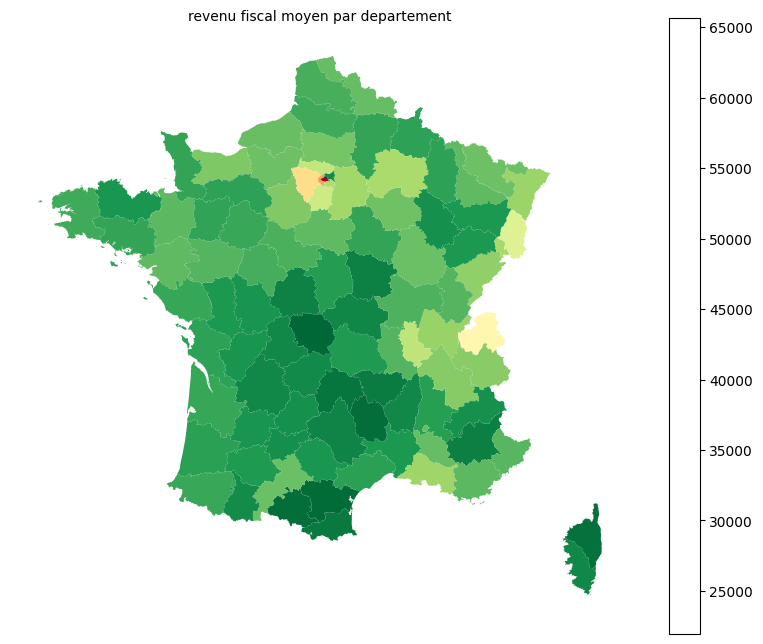

In [28]:
variable_to_plot = "revenu_fiscal_moyen_par_dep"

# Définir les valeurs de coloration
norm = mcolors.Normalize(vmin=merged_df[variable_to_plot].min(), vmax=merged_df[variable_to_plot].max())
cmap = plt.colormaps.get_cmap('RdYlGn_r')  # Utilisation de 'RdYlGn_r' pour aller du vert au rouge

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_df.plot(column=variable_to_plot, cmap=cmap, norm=norm, legend=True, ax=ax)

# Supprimer les axes gradués
ax.set_axis_off()

# Ajuster la taille de la barre colorée (legend)
cbar = ax.get_figure().get_axes()[1]
cbar.set_aspect(30)  # Ajuster la taille selon vos besoins

# Ajouter un titre
ax.set_title(f'revenu fiscal moyen par departement', fontdict={'fontsize': '10', 'fontweight': '3'})

# Afficher la carte
plt.show()

In [31]:
query = f"""
SELECT 
    departement, 
    AVG(prix_par_meter) as prix_par_meter_par_dep
FROM {prix_par_meter_tab_name}
WHERE year=2022 
GROUP BY departement
ORDER BY prix_par_meter_par_dep desc
"""

prix_par_meter_par_dep_df = conn.execute(query).fetchdf()

prix_par_meter_par_dep_df['departement'] = prix_par_meter_par_dep_df['departement'].astype(str).str.zfill(2)

prix_par_meter_par_dep_df.head()

,departement,prix_par_meter_par_dep
0,75,11138.324449
1,92,7620.273168
2,94,5748.541899
3,06,5077.064919
4,74,4824.068124


In [33]:
# join the prix_par_meter with map
merged_prix_df = fr_map.set_index('code').join(prix_par_meter_par_dep_df.set_index('departement'))
print(merged_prix_df.columns)

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry', 'prix_par_meter_par_dep'],
      dtype='object')


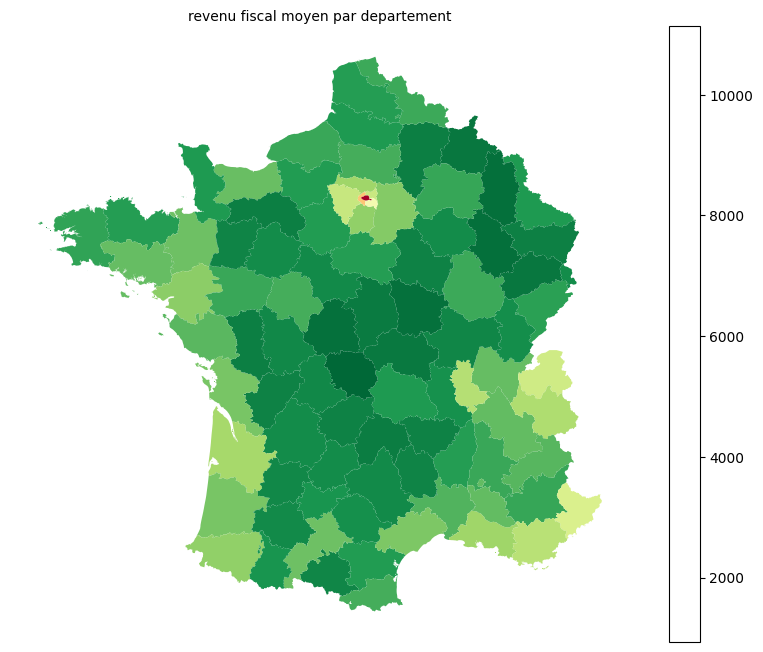

In [34]:
variable_to_plot = "prix_par_meter_par_dep"

# Définir les valeurs de coloration
norm = mcolors.Normalize(vmin=merged_prix_df[variable_to_plot].min(), vmax=merged_prix_df[variable_to_plot].max())
cmap = plt.colormaps.get_cmap('RdYlGn_r')  # Utilisation de 'RdYlGn_r' pour aller du vert au rouge

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_prix_df.plot(column=variable_to_plot, cmap=cmap, norm=norm, legend=True, ax=ax)

# Supprimer les axes gradués
ax.set_axis_off()

# Ajuster la taille de la barre colorée (legend)
cbar = ax.get_figure().get_axes()[1]
cbar.set_aspect(30)  # Ajuster la taille selon vos besoins

# Ajouter un titre
ax.set_title(f'revenu fiscal moyen par departement', fontdict={'fontsize': '10', 'fontweight': '3'})

# Afficher la carte
plt.show()

In [13]:
conn.close()